# Exotic Greeks: Arithmetic Asian & Barrier Options
Compute **Delta** and **Gamma** using central finite differences:
1. **Arithmetic Asian Call** (via Monte Carlo)
2. **Down-and-Out Barrier Call** (via Monte Carlo)

| Symbol         | Meaning                             | Value   |
|:--------------:|:-----------------------------------:|:-------:|
| $S_0$          | Initial spot price                  | **100** |
| $K$            | Strike price                        | 100     |
| $r$            | Risk-free rate                      | 5 %     |
| $\sigma$      | Volatility (annual)                 | 20 %    |
| $T$            | Time to maturity (years)            | 1.0     |
| Monte Carlo    | Sample paths                        | 200,000 |
| Steps per Path | For barrier detection (M)           | 100     |
| Bump size $h$  | Finite difference increment         | 0.01    |


In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# allow imports from pricing/ at repo root
sys.path.append(os.path.abspath("../.."))
from pricing.monte_carlo import mc_arithmetic_asian_price

# MC parameters
S0, K, r, sigma, T = 100, 100, 0.05, 0.20, 1.0
N_paths = 200_000
M_steps = 100  # for barrier MC
h = 1e-2  # bump size
seed = 42

In [2]:
def mc_barrier_down_out_call(S0, K, r, sigma, T, B, N_paths, M, seed=None):
    """
    Monte Carlo down-and-out barrier call price.
    """
    if seed is not None:
        np.random.seed(seed)
    dt = T / M
    payoffs = []
    for _ in range(N_paths):
        increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(
            dt
        ) * np.random.randn(M)
        S_path = S0 * np.exp(np.cumsum(increments))
        if np.min(S_path) <= B:
            payoffs.append(0.0)
        else:
            payoffs.append(max(S_path[-1] - K, 0.0))
    discounted = np.exp(-r * T) * np.array(payoffs)
    price = discounted.mean()
    stderr = discounted.std(ddof=1) / np.sqrt(N_paths)
    ci95 = 1.96 * stderr
    return price, ci95

In [3]:
def compute_greeks(price_func, S0, bump, **kwargs):
    base, _ = price_func(S0, **kwargs)
    up, _ = price_func(S0 + bump, **kwargs)
    down, _ = price_func(S0 - bump, **kwargs)
    delta = (up - down) / (2 * bump)
    gamma = (up - 2 * base + down) / (bump**2)
    return delta, gamma


# Price functions wrappers


def price_asian(S0, **kwargs):
    return mc_arithmetic_asian_price(S0, **kwargs)


def price_barrier(S0, **kwargs):
    return mc_barrier_down_out_call(S0, B=90, **kwargs)

In [4]:
# Compute Greeks
asian_delta, asian_gamma = compute_greeks(
    price_asian,
    S0,
    h,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    N_paths=N_paths,
    N_steps=252,
    seed=seed,
    is_call=True,
)
bar_delta, bar_gamma = compute_greeks(
    price_barrier,
    S0,
    h,
    K=K,
    r=r,
    sigma=sigma,
    T=T,
    N_paths=N_paths,
    M=M_steps,
    seed=seed,
)

df = pd.DataFrame(
    [
        {"Option": "Arithmetic Asian", "Delta": asian_delta, "Gamma": asian_gamma},
        {"Option": "Down-and-Out Barrier", "Delta": bar_delta, "Gamma": bar_gamma},
    ]
)
df

,Option,Delta,Gamma
0,Arithmetic Asian,0.588031,0.029361
1,Down-and-Out Barrier,0.801946,4.380016


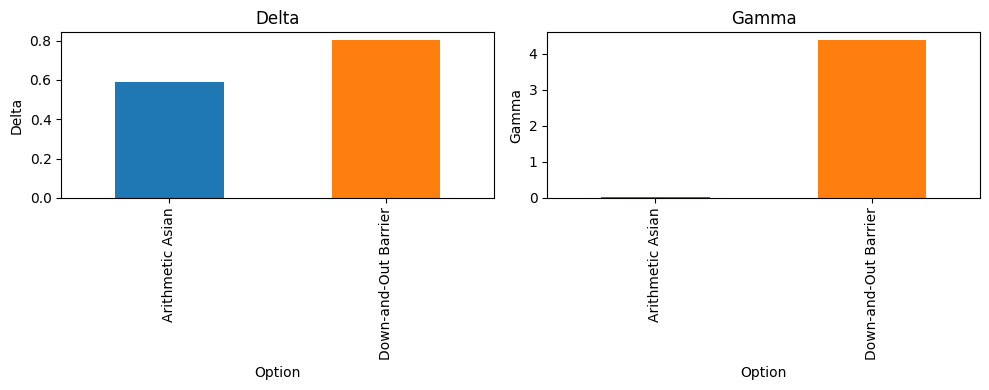

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.plot(
    x="Option",
    y="Delta",
    kind="bar",
    ax=axes[0],
    legend=False,
    color=["#1f77b4", "#ff7f0e"],
)
axes[0].set_title("Delta")
axes[0].set_ylabel("Delta")

df.plot(
    x="Option",
    y="Gamma",
    kind="bar",
    ax=axes[1],
    legend=False,
    color=["#1f77b4", "#ff7f0e"],
)
axes[1].set_title("Gamma")
axes[1].set_ylabel("Gamma")

plt.tight_layout()

# save the plot into plots folder
plt.savefig("../../plots/greeks_asian_barrier.png", dpi=300)

plt.show()

### Observations
- Asian call delta is lower than for vanilla, due to averaging.
- Barrier call delta is reduced compared to vanilla, reflecting knockout risk.
- Gamma curvature differs: barrier gamma is smoother.